<a href="https://colab.research.google.com/github/varunSabnis/pytorch_course_udemy/blob/master/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torch torchvision
!pip install Pillow==4.0.0

In [0]:
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 

In [0]:
vgg = models.vgg19(pretrained=False).features
for param in vgg.parameters():
  param.requires_grad_(False)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def load_image(img_path, max_size=400, shape=None):
  img = Image.open(img_path).convert('RGB')
  size = max(img.size)
  if size > max_size:
    size = max_size
  if shape is not None:
    size = shape
  in_transform = transforms.Compose([transforms.Resize(size),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5),
                                           (0.5, 0.5, 0.5))
                      ])
  img = in_transform(img).unsqueeze(0)
  return img

In [0]:
content = load_image('City.jpg').to(device)
style = load_image('StarryNight.jpg', shape=content.shape[-2:]).to(device)

In [0]:
def image_convert(im_tensor):
  image = im_tensor.cpu().clone().detach().numpy() 
  image = image.squeeze()
  image = image.transpose(1, 2, 0) # Change shape of image from 1*m*n to m*n*1
  image = image*(np.array((0.5, 0.5, 0.5))) + np.array((0.5, 0.5, 0.5)) 
  
  """
  y = (x - mean)/std
  x = y*std + mean  -- this will get back original image that was normalized
  """
  image = image.clip(0, 1) # Keep every pixel between 0 and 1
  return image

(-0.5, 599.5, 399.5, -0.5)

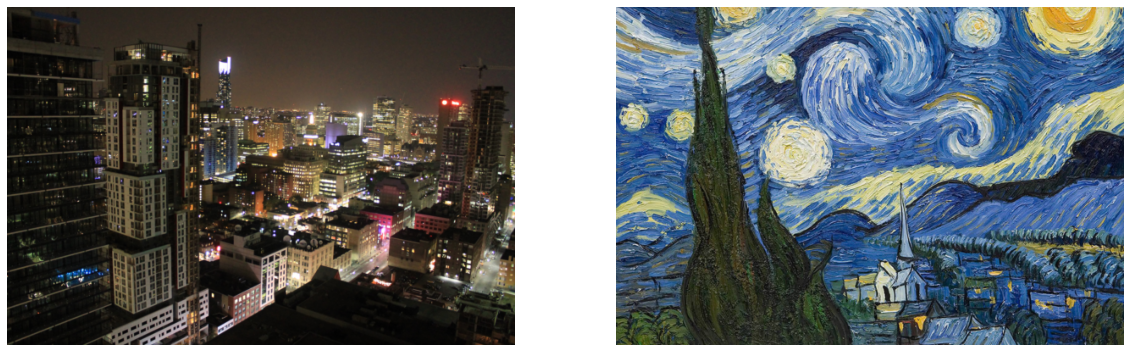

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image_convert(content))
ax1.axis('off')
ax2.imshow(image_convert(style))
ax2.axis('off')

In [0]:
def get_features(img, model):
  layers = {'0' : 'conv1_1',
            '5' : 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2', # content extraction 
            '28': 'conv5_1'}
  features = {}
  for name, layer in model._modules.items():
    img = layer(img)
    if name in layers:
      features[layers[name]] = img
  return features

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [0]:
def gram_matrix(tensor):
  _, d, h, w = tensor.size()
  tensor = tensor.view(d, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [0]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [0]:
style_weights = {'conv1_1': 1.,
                'conv2_1': 0.75,
                'conv3_1': 0.2,
                'conv4_1': 0.2,
                'conv5_1': 0.2}
alpha = 1 # content weight
beta = 1e6 # style weight

In [0]:
target = content.clone().requires_grad_(True).to(device)

In [0]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 2100
height, width, channels = image_convert(target).shape 
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/show_every
counter = 0

Iteration : 300
TOTAL LOSS : 304.8352355957031
CONTENT LOSS : 0.0008271372644230723
STYLE LOSS : 0.00030483442242257297


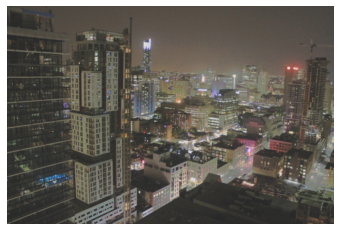

Iteration : 600
TOTAL LOSS : 124.84599304199219
CONTENT LOSS : 0.0006051899399608374
STYLE LOSS : 0.00012484539183788002


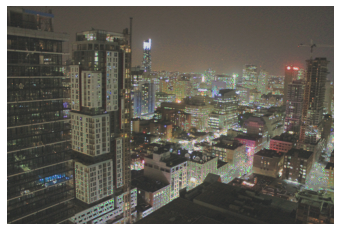

Iteration : 900
TOTAL LOSS : 12.010416030883789
CONTENT LOSS : 0.0008590879151597619
STYLE LOSS : 1.2009556485281792e-05


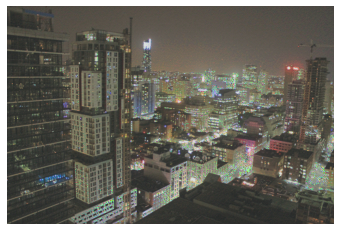

Iteration : 1200
TOTAL LOSS : 0.543404757976532
CONTENT LOSS : 0.0010329243959859014
STYLE LOSS : 5.423718221209128e-07


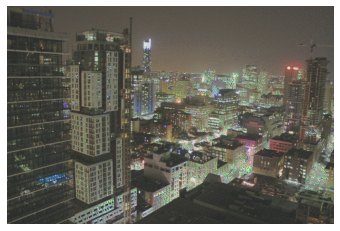

Iteration : 1500
TOTAL LOSS : 0.22822050750255585
CONTENT LOSS : 0.0010560203809291124
STYLE LOSS : 2.2716449166182429e-07


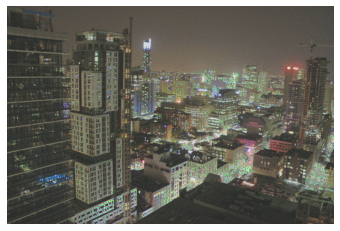

Iteration : 1800
TOTAL LOSS : 0.1898711770772934
CONTENT LOSS : 0.001047772355377674
STYLE LOSS : 1.8882340668824327e-07


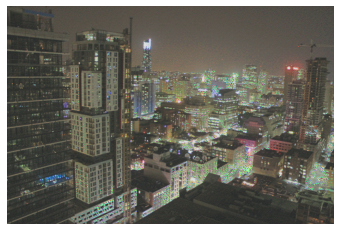

Iteration : 2100
TOTAL LOSS : 0.15629152953624725
CONTENT LOSS : 0.0010372529504820704
STYLE LOSS : 1.5525426988460822e-07


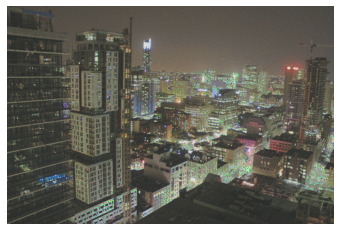

In [17]:
for ii in range(1,steps+1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer]*(torch.mean(target_gram - style_gram)**2)
    _,d,h,w = target_feature.shape
    style_loss += layer_style_loss/(h*w*d)
  total_loss = alpha*content_loss + beta*style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if ii % show_every == 0:
    print("Iteration : {}".format(ii))
    print("TOTAL LOSS : {}".format(total_loss.item()))
    print("CONTENT LOSS : {}".format(content_loss.item()))
    print("STYLE LOSS : {}".format(style_loss.item()))
    plt.imshow(image_convert(target))
    plt.axis('off')
    plt.show()

  if ii % capture_frame == 0:
    image_array[counter] = image_convert(target)
    counter = counter + 1


(-0.5, 599.5, 399.5, -0.5)

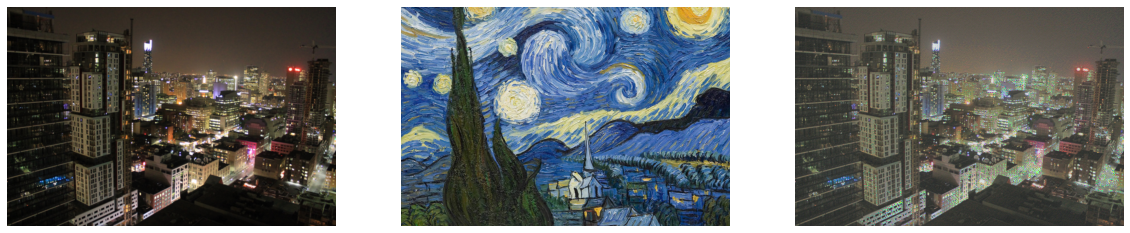

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(image_convert(content))
ax1.axis('off')
ax2.imshow(image_convert(style))
ax2.axis('off')
ax3.imshow(image_convert(target))
ax3.axis('off')